In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Libraries

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import Callback
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [31]:
# dataset path
path = '/kaggle/input/news-classification/bangla_news_classification.csv'

# Data Preparation

Total number of headlines: 43887


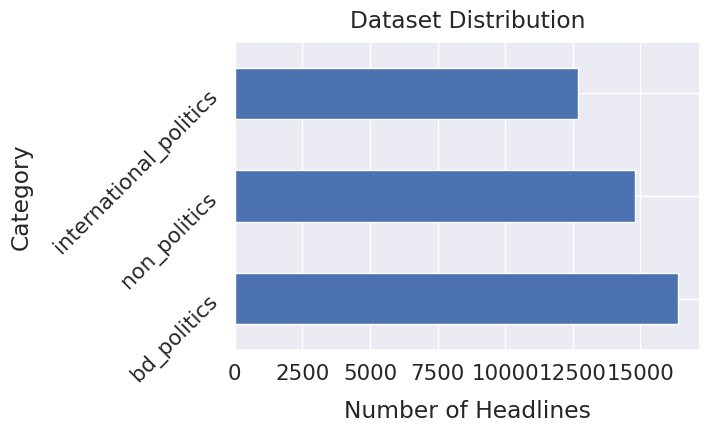

In [32]:
# data = pd.read_csv(path+'headlines.csv',encoding='utf-8')
data = pd.read_csv(path,encoding='utf-8')
print(f'Total number of headlines: {len(data)}')
sns.set(font_scale=1.4)
data['category'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [33]:
data.columns

Index(['headline', 'category'], dtype='object')

# Data Cleaning

In [36]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
      headlines = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return headlines
# Apply the function into the dataframe
data['cleaned'] = data['headline'].apply(cleaning_data)  

# Remove duplicates
data.drop_duplicates(subset='headline', keep='first', inplace=True)
data = data.reset_index(drop=True)
# print some cleaned reviews from the dataset
# sample_data = [2000,5000,10000,20000,30000,35000,40000,45000,50000,60000,65000,70000,75000,80000,100000]
sample_data = [2000,5000,10000,15000,20000]

for i in sample_data:
  print('Original: ',data.headline[i],'\nCleaned:',
           data.cleaned[i],'\n','Category:-- ',data.category[i],'\n')   

Original:  গৌতম বুদ্ধের জন্মস্থান যেভাবে খুঁজে পান এক বাঙালি 
Cleaned: গৌতম বুদ্ধের জন্মস্থান যেভাবে খুঁজে পান এক বাঙালি 
 Category:--  international_politics 

Original:  সু চি কোথায় আছেন না জানালেও ভালো আছেন, জানালো জান্তা 
Cleaned: সু চি কোথায় আছেন না জানালেও ভালো আছেন  জানালো জান্তা 
 Category:--  international_politics 

Original:  ফেনী-১ আসনে খালেদা জিয়ার মনোনয়ন বাতিল 
Cleaned: ফেনী ১ আসনে খালেদা জিয়ার মনোনয়ন বাতিল 
 Category:--  bd_politics 

Original:  সৎ নিয়ত ও আশা-আকাঙ্ক্ষা আল্লাহ কবুল করেন: তোফায়েল 
Cleaned: সৎ নিয়ত ও আশা আকাঙ্ক্ষা আল্লাহ কবুল করেন  তোফায়েল 
 Category:--  bd_politics 

Original:  জ্যাকলিনের মার্শাল আর্ট মিশন 
Cleaned: জ্যাকলিনের মার্শাল আর্ট মিশন 
 Category:--  non_politics 



# Remove Low Length Data

In [37]:
# Length of each headlines
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the headlines with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Headlines".format(len(data)-len(dataset)),
      "\nTotal Headlines:",len(dataset))

After Cleaning: 
Removed 185 Small Headlines 
Total Headlines: 35711


# Dataset Analysis

In [38]:
def data_summary(dataset):
    
    """
    This function will print the summary of the headlines and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.category.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.category==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.category==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.category==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:20]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)    



Class Name :  non_politics
Number of Documents:14271
Number of Words:86036
Number of Unique Words:17673
Most Frequent Words:

ও	578
না	576
নিয়ে	563
নতুন	419
হবে	388
বাংলাদেশ	358
থেকে	357
প্রধানমন্ত্রী	306
ভিডিও	299
শুরু	276
আজ	270
জন্য	266
সঙ্গে	266
মেসি	253
করে	208
নেই	203
করতে	201
যে	186
বাংলাদেশের	184
হচ্ছে	183

Class Name :  bd_politics
Number of Documents:12503
Number of Words:90341
Number of Unique Words:11819
Most Frequent Words:

খালেদা	1322
বিএনপি	1192
বিএনপির	1139
না	1061
কাদের	1038
আ	897
জিয়ার	850
লীগের	726
ফখরুল	623
হবে	601
লীগ	543
নিয়ে	494
ওবায়দুল	473
নির্বাচন	458
ও	440
মির্জা	421
আওয়ামী	415
জাতীয়	414
নেতা	378
সরকার	361

Class Name :  international_politics
Number of Documents:8937
Number of Words:70651
Number of Unique Words:12966
Most Frequent Words:

নিহত	740
গাজায়	443
হামলা	396
থেকে	395
নিয়ে	362
না	354
মৃত্যু	345
হামলায়	329
ইসরায়েলি	327
ও	317
ইসরায়েল	290
ইসরায়েলের	275
পর	248
ভারতে	234
করে	232
কী	228
ভারতের	218
সঙ্গে	204
নতুন	194
প্রেসিডেন্ট	183
Total Number of Unique 

# Summary Visualization

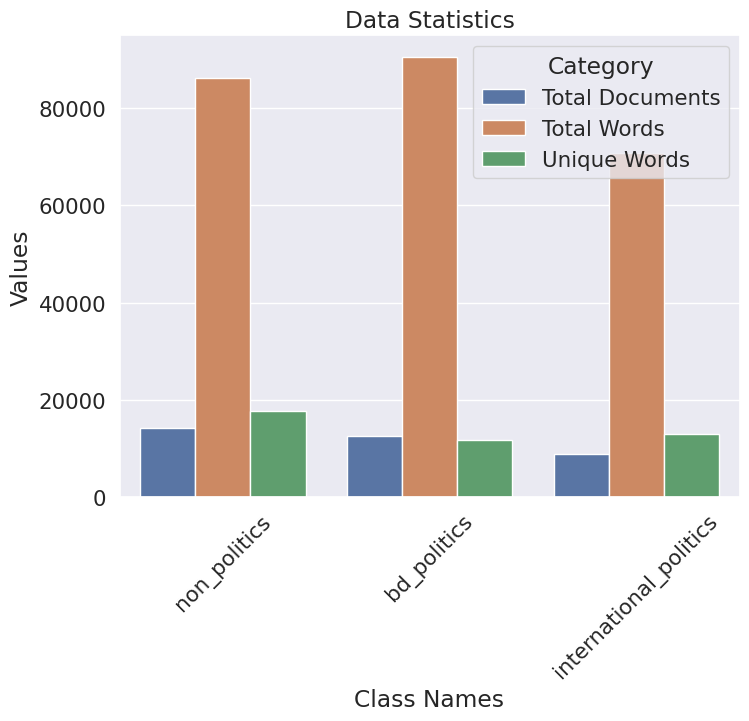

In [39]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

# Headline Length Distribution

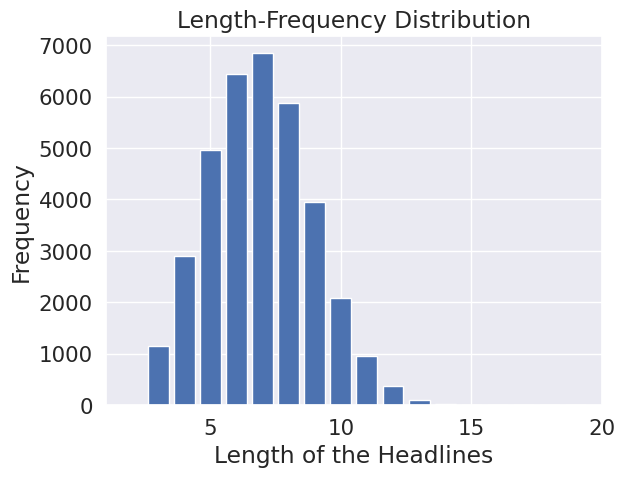

Maximum Length of a headline: 19
Minimum Length of a headline: 3
Average Length of a headline: 7.0


In [40]:
# Calculate the Review of each of the Review
dataset['HeadlineLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.HeadlineLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 20)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a headline: {max(dataset.HeadlineLength)}")
print(f"Minimum Length of a headline: {min(dataset.HeadlineLength)}")
print(f"Average Length of a headline: {round(np.mean(dataset.HeadlineLength),0)}")

# Lable Encoding and Dataset Splitting

In [41]:
                                      #==================================================
                                       ################# Label Encoding Function #########
                                       #==================================================

def label_encoding(category,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        category: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(category)
    encoded_labels = le.transform(category)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(category[i],' ', encoded_labels[i],'\n')

    return labels



                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #=========================================================== 

def dataset_split(headlines,category):
    """
    This function will return the splitted (90%-10%-10%) feature vector . 
    
    Args:
        headlines: sequenced headlines 
        category: encoded lables (array) 
        
    Returns:
        X_train: training data 
        X_valid: validation data
        X_test : testing feature vector 
        y_train: training encoded labels (array) 
        y_valid: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.8,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test


In [42]:
labels = label_encoding(dataset.category,True)


			===== Label Encoding ===== 
Class Names:--> ['bd_politics' 'international_politics' 'non_politics']
international_politics   1 

international_politics   1 

bd_politics   0 

bd_politics   0 

non_politics   2 



In [43]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.headline,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 35711 
	Training		 22854 
	Test			 3572 
	Validation		 5714


# Tokenization

In [45]:
# import pandas as pd
# from collections import Counter
# import re


# # Function to tokenize text
# def tokenize(text):
#     # Remove punctuation and convert to lower case
#     text = re.sub(r'[^\w\s]', '', text.lower())
#     # Split text into words
#     return text.split()

# # Apply tokenization to the 'headline' column
# tokens = data['headline'].apply(tokenize)

# # Flatten the list of tokens and count unique words
# all_tokens = [token for sublist in tokens for token in sublist]
# vocab_size = len(set(all_tokens))

# print("Vocabulary size:", vocab_size)


In [47]:
vocab_size = 29396
embedding_dim = 64
max_length = 21
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

def padded_headlines(original,encoded,padded):
  '''
  print the samples padded headlines
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")  
  print(original,"\n",encoded) 
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded)  

In [48]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)


In [49]:
 #============================== Tokenizer Info =================================
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  #=============================== Print all the information =========================
print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
না 	 1194
নিয়ে 	 890
খালেদা 	 860
ও 	 852
বিএনপি 	 749
বিএনপির 	 744
কাদের 	 727
থেকে 	 711
হবে 	 668
জিয়ার 	 586

Words --> Documents:
না 	 1154
নিয়ে 	 887
খালেদা 	 860
ও 	 847
বিএনপি 	 748
বিএনপির 	 744
কাদের 	 724
থেকে 	 710
হবে 	 663
জিয়ার 	 586

Words --> Index:
কুষ্টিয়ার 	 25826
ব্রিটানিয়ার 	 25825
লিফটে 	 25824
সদস্যদেরকে 	 25823
পদদলন 	 25822
‘আনুষ্ঠানিক’ 	 25821
লুর 	 25820
চিকুনগুনিয়ার 	 25819
ত্যাগীদের 	 25818
জার্নাল 	 25817

Total Documents --> 22854
Found 25826 unique tokens


In [51]:
# padded_headlines(X_train[10],train_sequences[10],train_padded[10]) 

In [52]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
# padded_headlines(X_valid[1],validation_sequences[1],validation_padded[1]) 


In [53]:
X_test

26297                            ট্রফিটা রাখবে কোথায় রিয়াল
16886                     আজই তফসিল চায় সম্মিলিত জাতীয় জোট
29884                   ঢাকার বাইরে ১২৩ ডেঙ্গু রোগী শনাক্ত
19552                           রাজনীতিকে ভয় পাই: আমির খান
23127             ৫০০ উদ্যোক্তাকে প্রশিক্ষণ দেবে সিস্টেমআই
                               ...                        
1921                 হামাস-ফাতাহ বৈরিতা শুরু হয়েছিল যেভাবে
4034     মার্কিন বাহিনীর প্রত্যাহার চায় ইরাক, পরিকল্পনা...
14093               ‘অবৈধ টাকা সংসারে খরচ করতেন না সম্রাট’
14486           কুষ্টিয়া-২: দুই জোটের শরীক দলে বড় প্রার্থী
17999               সংসদ নির্বাচনে যাচ্ছে জাতীয় ঐক্যফ্রন্ট
Name: headline, Length: 3572, dtype: object

In [54]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
# padded_headlines(X_test[15542],test_sequences[0],test_padded[0]) 

In [55]:
# Labels Tokenization
#label_tokenizer = Tokenizer()
#label_tokenizer.fit_on_texts(dataset.category)

train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

#print(train_label_seq.shape)
#print(valid_label_seq.shape)
#print(testing_label_seq.shape)

#Model Defination

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import Callback

# Clear previous session
keras.backend.clear_session()

# Hyperparameters
accuracy_threshold = 0.97
vocab_size = 29396
embedding_dim = 64
max_length = 21
num_category = 3

# Custom callback to stop training at the desired accuracy
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs and logs.get('accuracy') > accuracy_threshold:
            print(f"\nReached {accuracy_threshold * 100:.2f}% accuracy so we will stop training")
            self.model.stop_training = True

# Callback instances
acc_callback = myCallback()
filepath = "/kaggle/working/Model.keras"  # Updated file extension
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint]

# Building the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(GRU(64, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_category, activation='softmax')
])

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
num_epochs = 3
batch = 64
history = model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/10
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6452 - loss: 0.7490
Epoch 1: val_accuracy improved from -inf to 0.89254, saving model to /kaggle/working/Model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.6460 - loss: 0.7477 - val_accuracy: 0.8925 - val_loss: 0.3079
Epoch 2/10
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9403 - loss: 0.1773
Epoch 2: val_accuracy did not improve from 0.89254
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9403 - loss: 0.1773 - val_accuracy: 0.8840 - val_loss: 0.3367
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9759 - loss: 0.0812
Reached 97.00% accuracy so we will stop training

Epoch 3: val_accuracy did not improve from 0.89254
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9759 - loss: 0.0812 - val_accuracy: 0.8773 - val_loss: 0.3918


## Confusion Matrix

In [63]:
data['category'].unique()

array(['international_politics', 'bd_politics', 'non_politics'],
      dtype=object)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


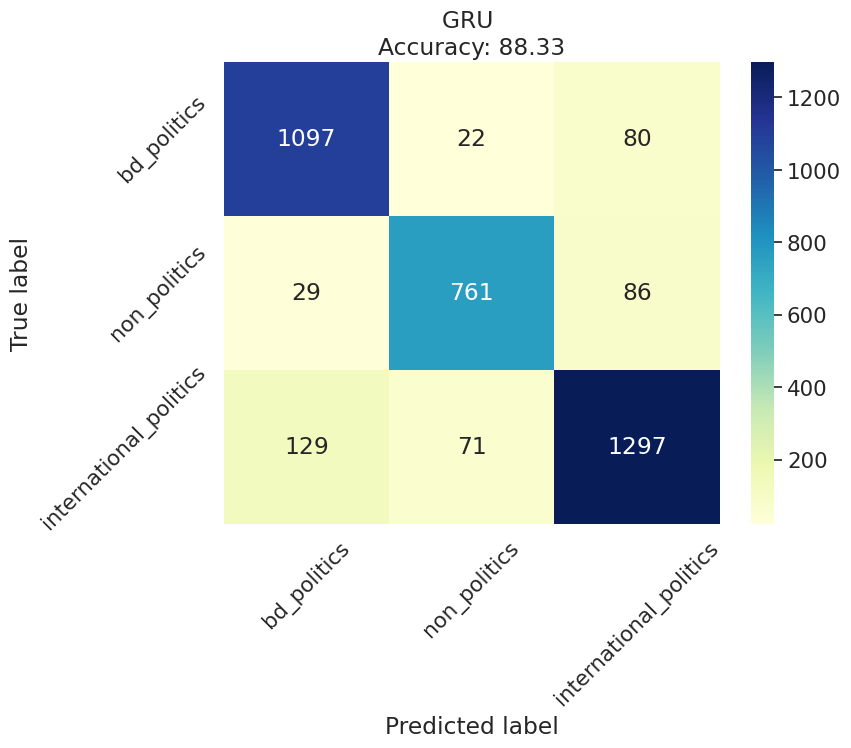

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
model = load_model("/kaggle/working/Model.keras")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_label_seq, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     
                     index = ['bd_politics' ,'non_politics','international_politics' ], 
                     columns = ['bd_politics' ,'non_politics','international_politics'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
plt.title('GRU \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [66]:
report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'bd_politics','1':'non_politics','2':'international_politics'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
bd_politics,87.41,91.49,89.41,1199.000000
neutral,89.11,86.87,87.98,876.000000
international_politics,88.65,86.64,87.64,1497.000000
accuracy,88.33,88.33,88.33,0.883259
macro avg,88.39,88.34,88.34,3572.000000
weighted avg,88.35,88.33,88.31,3572.000000


In [67]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Define the input sentence
input_sentence = "আমি শেখ হাসিনা  , আওয়ামী লীগ করি"

# Load the saved model
model = load_model("/kaggle/working/Model.keras")

# Preprocess the input sentence
# Tokenize the sentence
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit the tokenizer on training texts

# Convert the input sentence to a sequence of tokens
input_sequence = tokenizer.texts_to_sequences([input_sentence])

# Pad the sequence to the maximum length
input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

# Predict the category
predictions = model.predict(input_padded)
predicted_label_index = np.argmax(predictions, axis=1)[0]

# Manually create the mapping from indices to label names
index_to_label = {0: 'bd_politics', 1: 'non_politics',2:'international_politics'}

# Get the predicted label
predicted_label = index_to_label.get(predicted_label_index, "Unknown label")

print(f"Input Sentence: {input_sentence}")
print(f"Predicted Category: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
Input Sentence: আমি শেখ হাসিনা  , আওয়ামী লীগ করি
Predicted Category: bd_politics


In [74]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Define the input sentence
input_sentence = "আমি সিয়াম , মেশিন লার্নিং করি  "

# Load the saved model
model = load_model("/kaggle/working/Model.keras")

# Preprocess the input sentence
# Tokenize the sentence
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit the tokenizer on training texts

# Convert the input sentence to a sequence of tokens
input_sequence = tokenizer.texts_to_sequences([input_sentence])

# Pad the sequence to the maximum length
input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

# Predict the category
predictions = model.predict(input_padded)
predicted_label_index = np.argmax(predictions, axis=1)[0]

# Manually create the mapping from indices to label names
index_to_label = {0: 'bd_politics',  2: 'non_politics',1:'international_politics'}

# Get the predicted label
predicted_label = index_to_label.get(predicted_label_index, "Unknown label")

print(f"Input Sentence: {input_sentence}")
print(f"Predicted Category: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Input Sentence: আমি সিয়াম , মেশিন লার্নিং করি  
Predicted Category: non_politics


In [72]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Define the input sentence
input_sentence = "আমি জো বাইডেন   , আমেরিকায় থাকি "

# Load the saved model
model = load_model("/kaggle/working/Model.keras")

# Preprocess the input sentence
# Tokenize the sentence
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit the tokenizer on training texts

# Convert the input sentence to a sequence of tokens
input_sequence = tokenizer.texts_to_sequences([input_sentence])

# Pad the sequence to the maximum length
input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

# Predict the category
predictions = model.predict(input_padded)
predicted_label_index = np.argmax(predictions, axis=1)[0]

# Manually create the mapping from indices to label names
index_to_label = {0: 'bd_politics',  2: 'non_politics',1:'international_politics'}

# Get the predicted label
predicted_label = index_to_label.get(predicted_label_index, "Unknown label")

print(f"Input Sentence: {input_sentence}")
print(f"Predicted Category: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Input Sentence: আমি জো বাইডেন   , আমেরিকায় থাকি 
Predicted Category: international_politics


# Use LSTM model 

In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback

# Clear previous session
keras.backend.clear_session()

# Hyperparameters
accuracy_threshold = 0.97
vocab_size = 29396
embedding_dim = 64
max_length = 21
num_category = 3

# Custom callback to stop training at the desired accuracy
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs and logs.get('accuracy') > accuracy_threshold:
            print(f"\nReached {accuracy_threshold * 100:.2f}% accuracy so we will stop training")
            self.model.stop_training = True

# Callback instances
acc_callback = myCallback()
filepath = "/kaggle/working/Model.keras"  # Updated file extension
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint]

# Building the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2)),  # Replaced GRU with LSTM
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(num_category, activation='softmax')
])

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [80]:
num_epochs = 3
batch = 64
history = model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/3
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6139 - loss: 0.8005
Epoch 1: val_accuracy improved from -inf to 0.88957, saving model to /kaggle/working/Model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.6147 - loss: 0.7992 - val_accuracy: 0.8896 - val_loss: 0.3052
Epoch 2/3
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9413 - loss: 0.1835
Epoch 2: val_accuracy improved from 0.88957 to 0.89184, saving model to /kaggle/working/Model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9413 - loss: 0.1835 - val_accuracy: 0.8918 - val_loss: 0.3033
Epoch 3/3
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9767 - loss: 0.0808
Reached 97.00% accuracy so we will stop training

Epoch 3: val_accuracy did not improve from 0.89184
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9767 - loss: 0.0808 - val_accuracy: 0.8840 - val_loss: 0.3739


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


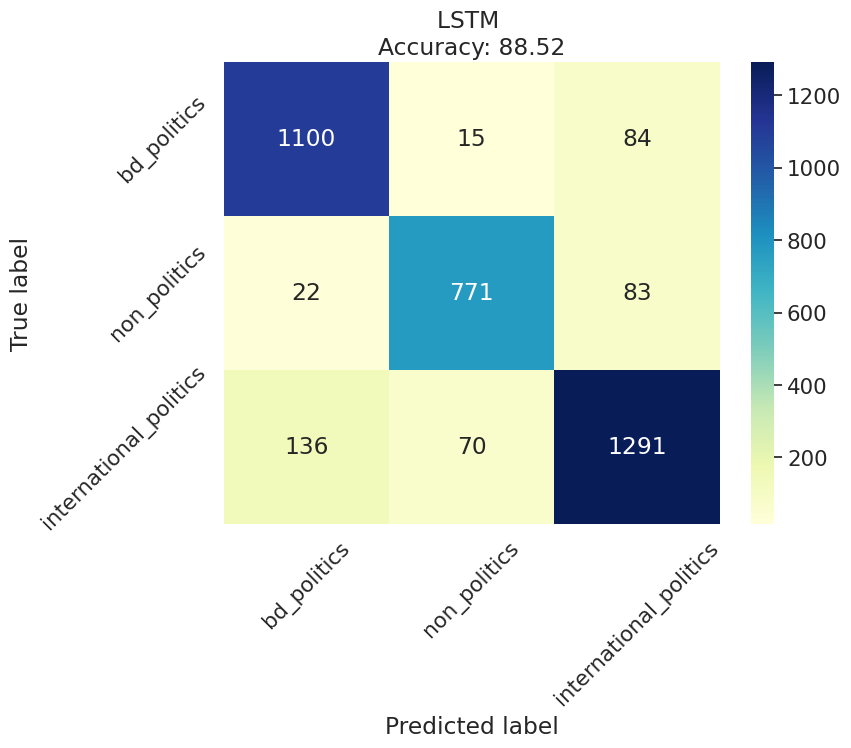

In [82]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
model = load_model("/kaggle/working/Model.keras")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_label_seq, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     
                     index = ['bd_politics' ,'non_politics','international_politics' ], 
                     columns = ['bd_politics' ,'non_politics','international_politics' ])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
plt.title('LSTM \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [83]:
report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'bd_politics','2': 'non_politics','1':'international_politics'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
bd_politics,87.44,91.74,89.54,1199.000000
international_politics,90.07,88.01,89.03,876.000000
non_politics,88.55,86.24,87.38,1497.000000
accuracy,88.52,88.52,88.52,0.885218
macro avg,88.69,88.67,88.65,3572.000000
weighted avg,88.55,88.52,88.51,3572.000000
